In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from gaussian_mixture_anomaly_detection import GaussianMixtureInTimeAnomalyDetector
import matplotlib.pyplot as plt
%matplotlib inline

простой пример: 10 двумерных временных рядов по 10 элементов в каждом,лежащие на 3x=2y со случайным нормальным смещением, а также 4 аномальные точки

In [2]:
T = 10
F = 40
N = 2

data = np.zeros((F, T, N))

for i in range(F):
    for t in range(T):
        data[i][t] = np.array([2,3]) * t + sps.norm.rvs(size=2,scale=0.5)
        
anomalies = [(0,5,0), (1,3,1), (1,4,1), (2,8,1), (3,2,0)]
for a in anomalies:
    data[a[0]][a[1]][a[2]] += 5

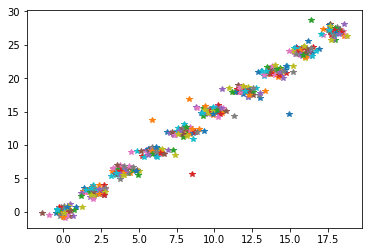

In [3]:
for i in range(F):
    plt.plot(data[i][:, 0], data[i][:, 1], '*')

In [4]:
detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=1)

In [5]:
scores = detector.fit(data)  # scores  - лограифмическое правдоподобие нормальности для каждого сэмпла

выявление аномальных сэмплов:

In [6]:
detector.find_anomalies(scores, log_likelihood_threshold=0)

([(-19.971168636993369, (0, 5)),
  (-19.768874549399268, (3, 2)),
  (-11.941563458523634, (1, 3)),
  (-9.672143419617651, (1, 4)),
  (-9.2187672499846176, (2, 8)),
  (-1.7360857659377855, (5, 0)),
  (-1.213296284714561, (37, 5)),
  (-0.96051771500878957, (30, 8)),
  (-0.3634331796349819, (8, 0)),
  (-0.23615455402012858, (28, 7))],
 0)

In [7]:
detector.find_anomalies(scores, anomaly_top=0.05)

([(-19.971168636993369, (0, 5)),
  (-19.768874549399268, (3, 2)),
  (-11.941563458523634, (1, 3)),
  (-9.672143419617651, (1, 4)),
  (-9.2187672499846176, (2, 8)),
  (-1.7360857659377855, (5, 0)),
  (-1.213296284714561, (37, 5)),
  (-0.96051771500878957, (30, 8)),
  (-0.3634331796349819, (8, 0)),
  (-0.23615455402012858, (28, 7)),
  (0.12515004525629395, (4, 6)),
  (0.20969000876470681, (36, 3)),
  (0.29296561884886363, (36, 0)),
  (0.35115311050394998, (23, 1)),
  (0.39801617507520431, (20, 8)),
  (0.41519574074531701, (39, 4)),
  (0.42164889219800439, (14, 7)),
  (0.6807669715133331, (32, 2)),
  (0.70739470136012839, (17, 2)),
  (0.83311048343473493, (24, 9)),
  (0.85376805313819404, (38, 3))],
 0.85376805313819404)

как видно аномалии попали в топ 5%

In [8]:
detector.find_anomalies(scores, anomaly_top=0.1, strategy='series')

([(0.37586506950723564, 0),
  (1.3469545408909949, 1),
  (5.0484382569262483, 3),
  (13.701465673214212, 36),
  (14.585151632088134, 2)],
 14.585151632088134)

2 ряда с добавленными аномалиями попали в топ по сумме логорифимических правдоподобий

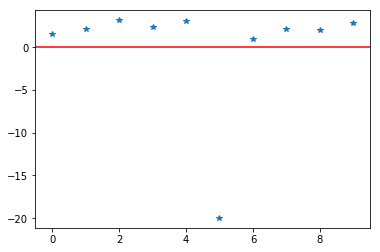

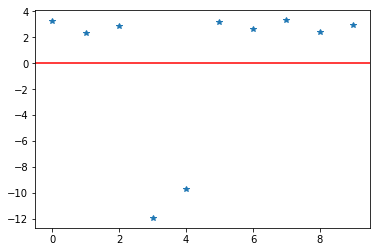

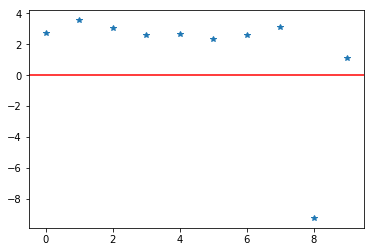

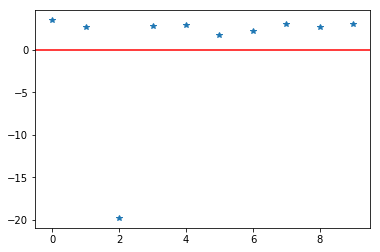

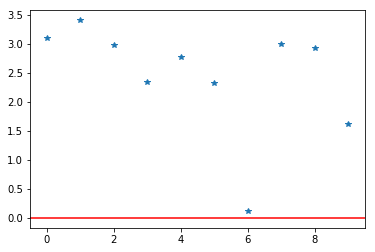

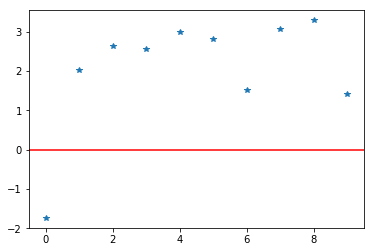

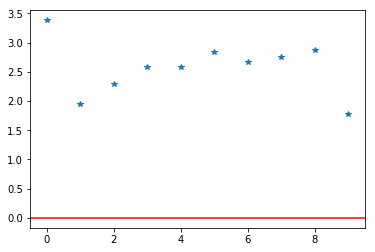

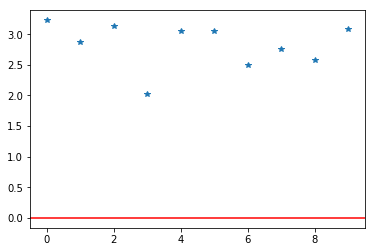

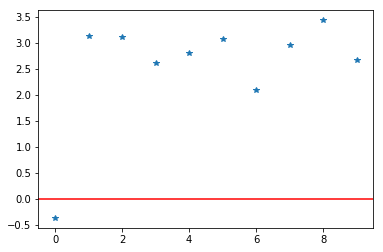

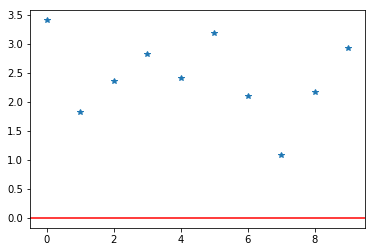

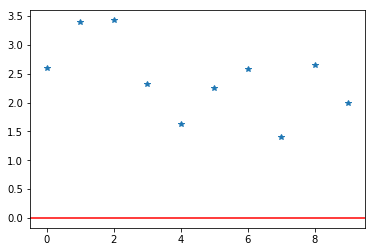

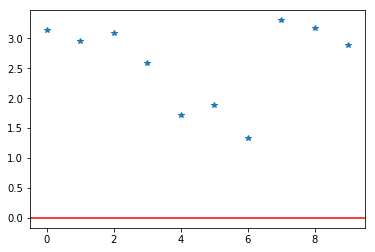

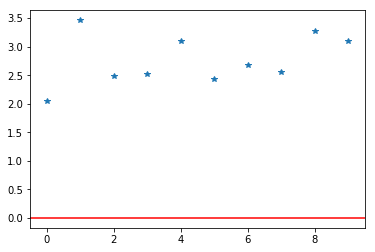

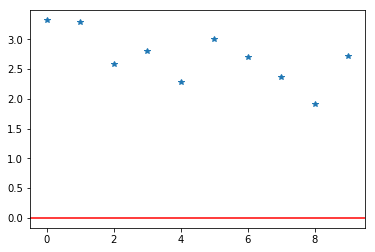

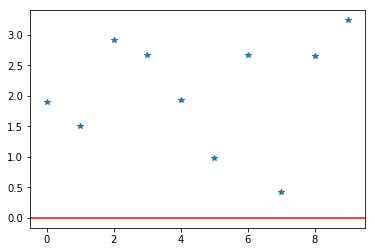

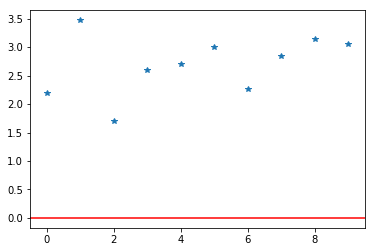

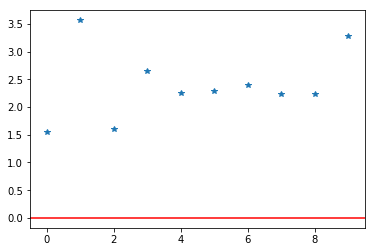

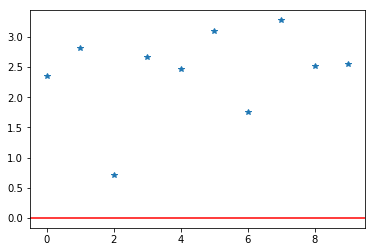

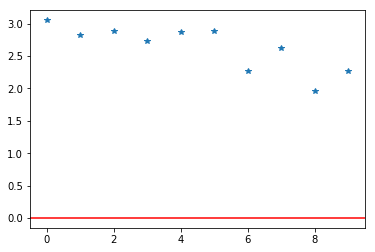

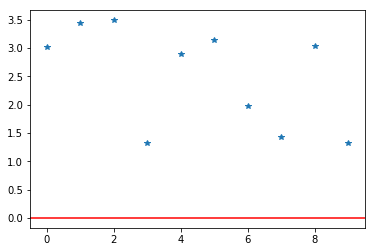

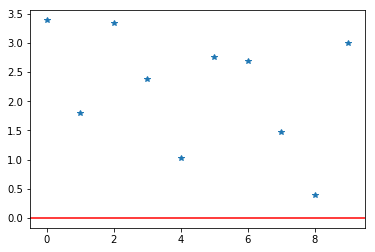

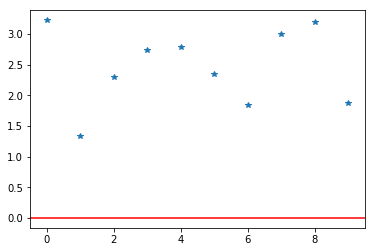

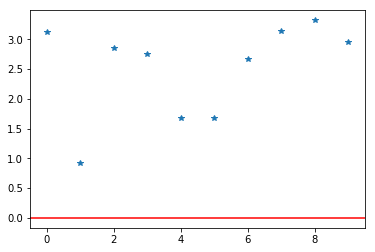

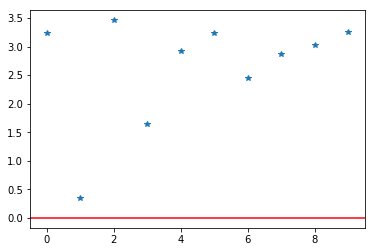

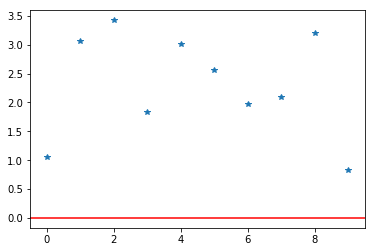

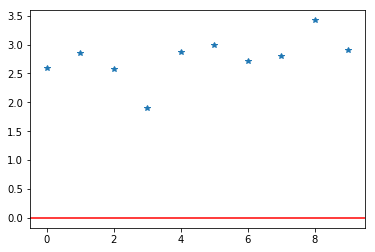

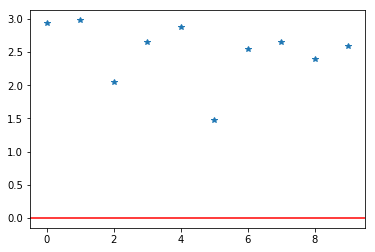

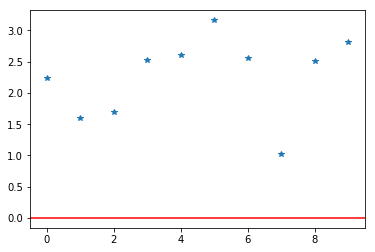

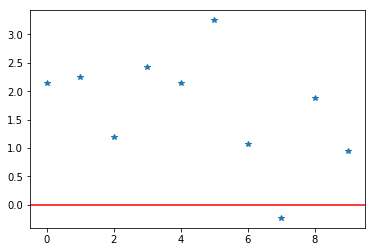

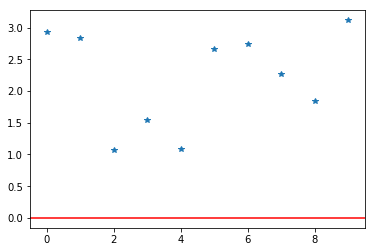

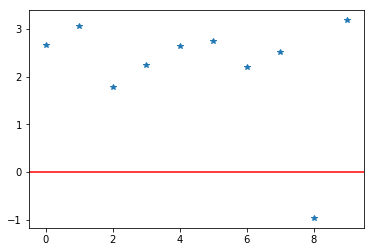

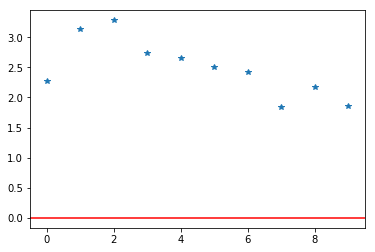

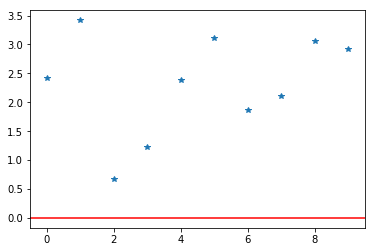

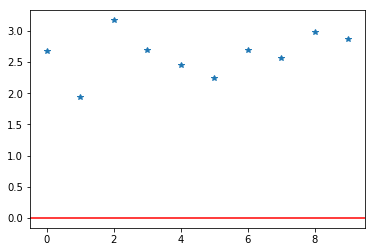

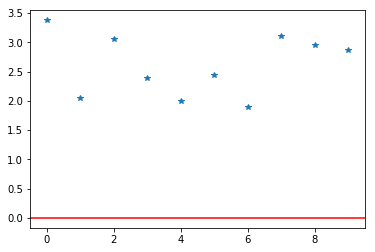

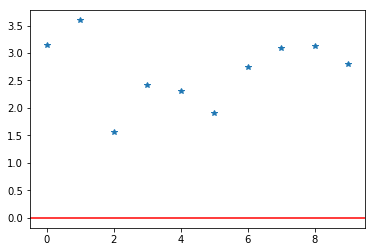

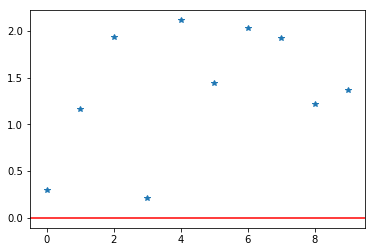

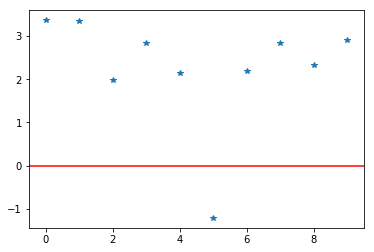

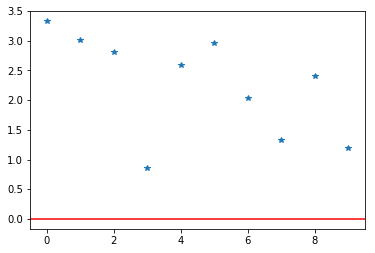

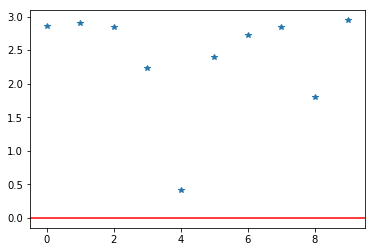

In [9]:
for f in range(F):
    plt.plot(range(T), scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [10]:
smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife=2)

/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:171: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


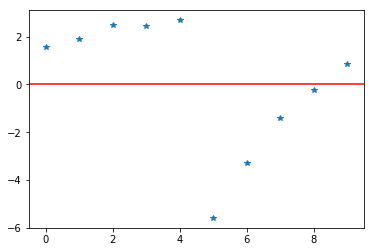

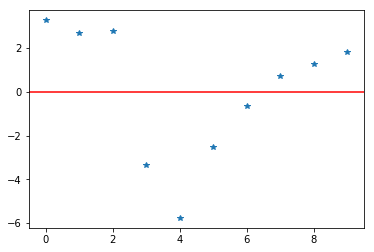

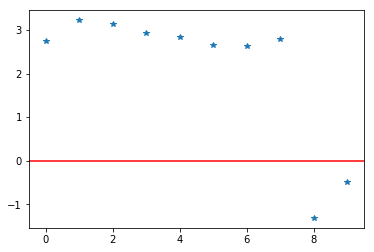

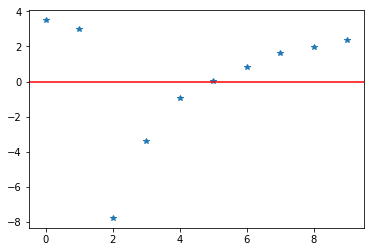

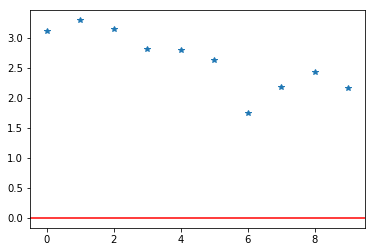

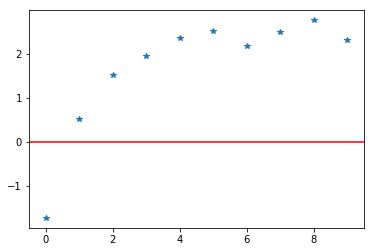

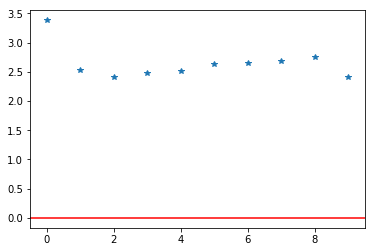

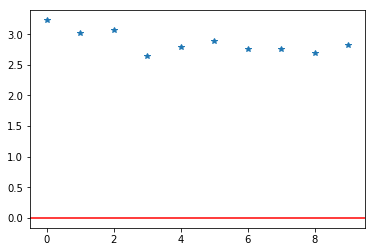

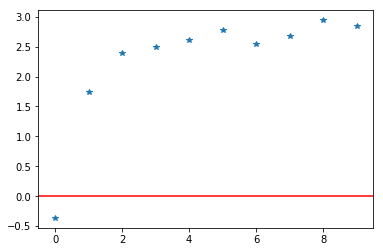

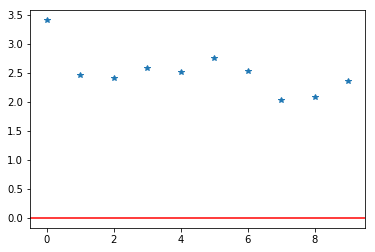

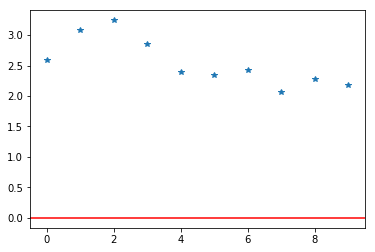

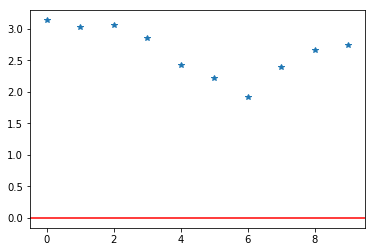

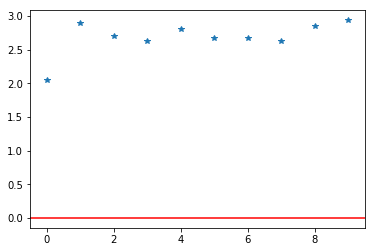

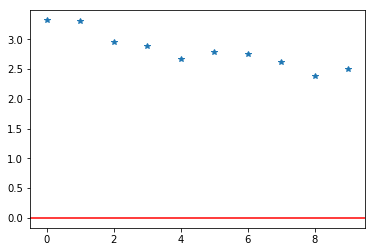

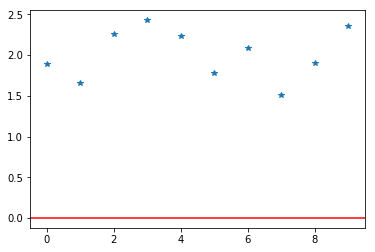

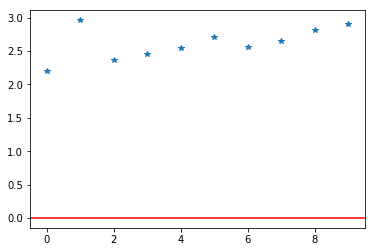

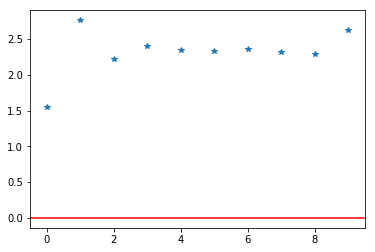

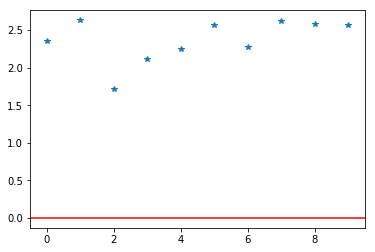

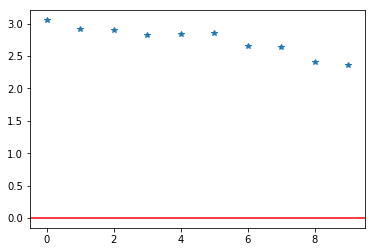

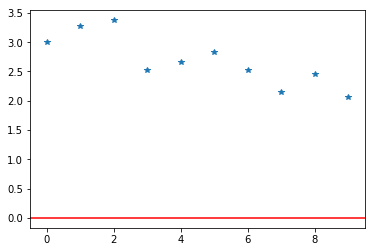

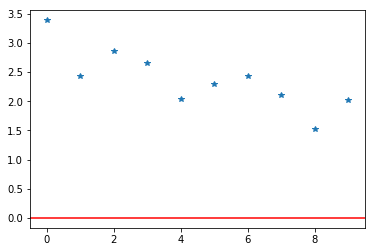

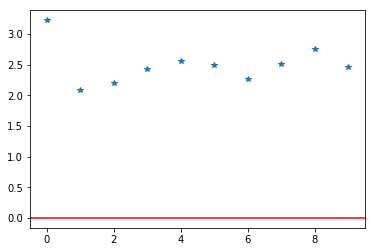

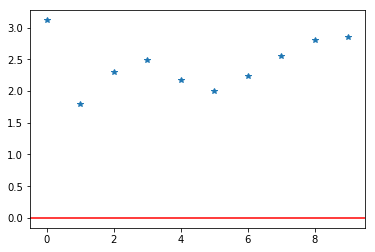

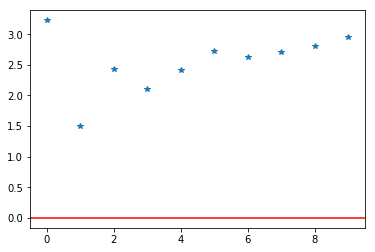

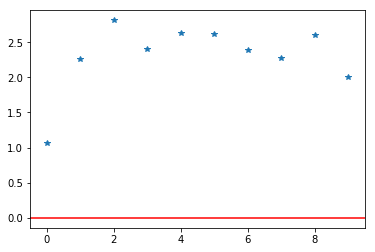

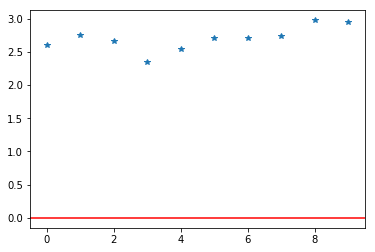

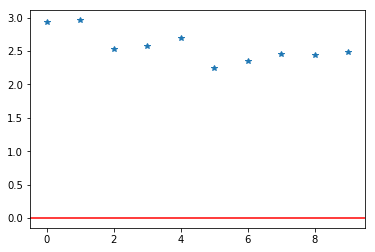

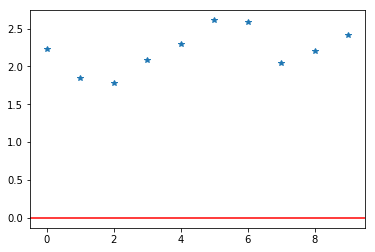

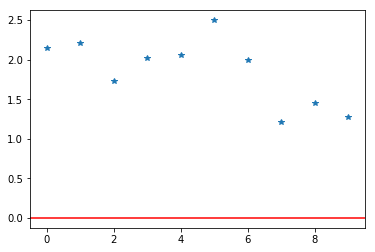

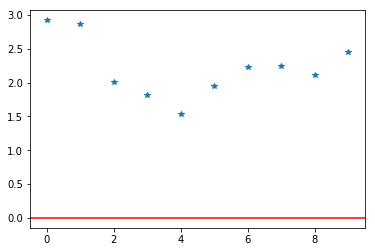

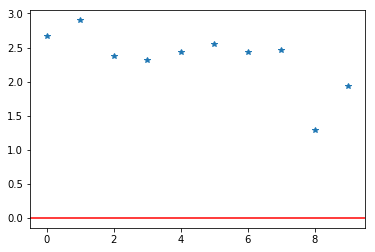

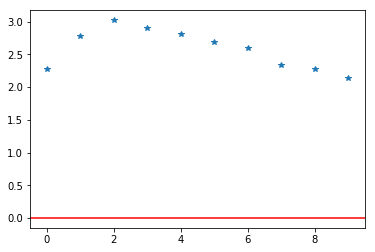

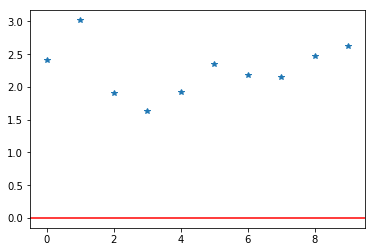

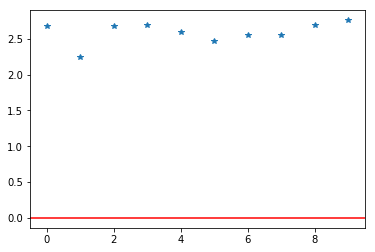

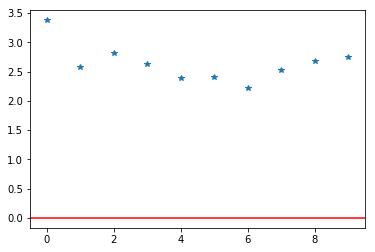

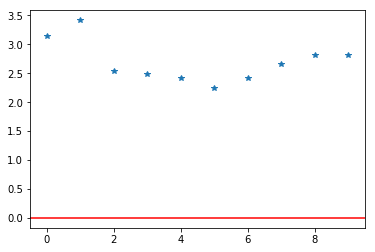

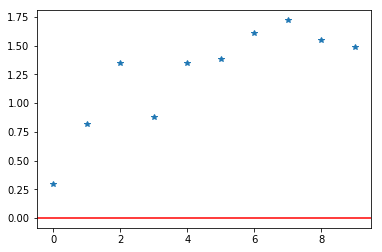

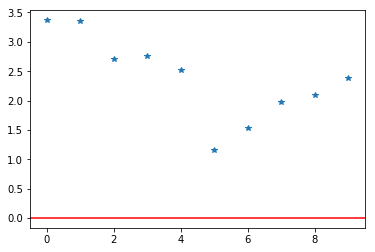

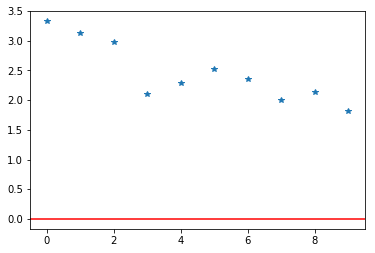

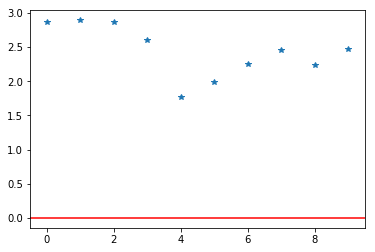

In [11]:
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [12]:
def extract_anomaly_target(frame, frame_period, halflife, 
                            horizont, n_components=35, top=0.01):
    assert len(frame.shape) == 2
    assert isinstance(frame, pd.DataFrame)
    data = np.array(frame).reshape(frame_period, -1, frame.shape[1])
    detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=1)
    # scores  - лограифмическое правдоподобие нормальности для каждого сэмпла
    scores = detector.fit(data)  
    smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife)
    anomalies, treshold = detector.find_anomalies(scores, anomaly_top=top)
    anomaly_indexes = [t[1][0] * frame_period + t[1][1] for t in anomalies]
    all_anomalies = set()
    assert np.max(anomaly_indexes) < frame.shape[0]
    for a in anomaly_indexes:
        for l in np.arange(horizont):
            all_anomalies.add(a - l)
            
    targets = np.zeros(frame.shape[0])
    
    for a in all_anomalies:
        targets[a] = 1
    
    return targets

In [13]:
targets = extract_anomaly_target(pd.DataFrame(data.reshape(40 * 10, 2)), 40, 1, 2, 10, 0.01)

/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:171: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=1,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


In [14]:
targets2d = targets.reshape((10,10))
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()
    print(targets2d[f])

ValueError: cannot reshape array of size 400 into shape (10,10)